# Retrieve bioactivity data from ChEMBL database
 A follow along project on drug discovery for *Zaire ebolavirus*

Target protein: **Human GAR transformylase**

Digital Mentor: Data Professor

###Install and import libraries

Install CheMBL web service package

In [1]:
!pip install chembl_webresource_client

     |████████████████████████████████| 61kB 3.5MB/s 
  Created wheel for chembl-webresource-client: filename=chembl_webresource_client-0.10.2-cp36-none-any.whl size=55663 sha256=0334b94e7ded518b79b2d9c7edd990f103612f2416e3bccbb3de4eb7054c75eb
  Stored in directory: /root/.cache/pip/wheels/e6/96/19/3f042bfda7c669bfe24c8278477f57b0fbbf3e488b4c09e3a8
Successfully built chembl-webresource-client


Import libraries

In [3]:
import pandas as pd
from chembl_webresource_client.new_client import new_client
import matplotlib.pyplot as plt

###Search for the target protein

In [5]:
# retrieve data for Subtilisin/kexin type 6
target = new_client.target
target_query = target.search('GAR transformylase')
targets = pd.DataFrame.from_dict(target_query)
targets.head()

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P22102', 'xref_name': None, 'xre...",Homo sapiens,GAR transformylase,30.0,False,CHEMBL3972,"[{'accession': 'P22102', 'component_descriptio...",SINGLE PROTEIN,9606
1,[],Mus musculus,GAR transformylase,30.0,False,CHEMBL3690,"[{'accession': 'Q64737', 'component_descriptio...",SINGLE PROTEIN,10090
2,[],Homo sapiens,GAR transformylase/AICAR transformylase,28.0,False,CHEMBL3430882,"[{'accession': 'P31939', 'component_descriptio...",PROTEIN FAMILY,9606
3,[],Homo sapiens,Thymidylate synthase/GAR transformylase/AICAR ...,23.0,False,CHEMBL3885528,"[{'accession': 'P04818', 'component_descriptio...",PROTEIN FAMILY,9606
4,"[{'xref_id': 'P31939', 'xref_name': None, 'xre...",Homo sapiens,AICAR transformylase,14.0,False,CHEMBL2518,"[{'accession': 'P31939', 'component_descriptio...",SINGLE PROTEIN,9606


In [ ]:
# select Human Subtilisin/kexin type 6 (index = 1)
target_protein = targets.iloc[0,:]
target_id = target_protein['target_chembl_id']
print(target_id)

CHEMBL3972


###Retrieve the bioactivity data for *Human GAR transformylase (CHEMBL3972)*

In [ ]:
activity = new_client.activity
res = activity.filter(target_chembl_id=target_id).filter(standard_type='IC50')
df = pd.DataFrame.from_dict(res)
print(df.shape)
df.head()

(90, 43)


,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,210224,[],CHEMBL680253,Compound was evaluated for the inhibition of g...,B,BAO_0000190,BAO_0000357,single protein format,NCCCC(NC(=O)c1ccc(NCC2CNc3nc(N)nc(O)c3C2)cc1)C...,None,None,CHEMBL1126177,J. Med. Chem.,1992,"{'bei': '12.38', 'le': '0.23', 'lle': '4.94', ...",CHEMBL289923,None,CHEMBL289923,5.32,False,http://www.openphacts.org/units/Nanomolar,105786,=,1,True,=,None,IC50,nM,None,4800.0,CHEMBL3972,Homo sapiens,GAR transformylase,9606,None,None,I50,uM,UO_0000065,None,4.8
1,None,226057,[],CHEMBL678861,Inhibition activity against Glycinamide ribonu...,B,BAO_0000190,BAO_0000219,cell-based format,Nc1nc(N)c(CCCN(C=O)c2ccc(C(=O)NC(CCC(=O)O)C(=O...,None,None,CHEMBL1125043,J. Med. Chem.,1990,"{'bei': '10.30', 'le': '0.20', 'lle': '4.75', ...",CHEMBL152172,None,CHEMBL152172,4.75,False,http://www.openphacts.org/units/Nanomolar,299724,=,1,True,=,None,IC50,nM,None,18000.0,CHEMBL3972,Homo sapiens,GAR transformylase,9606,None,None,IC50,uM,UO_0000065,None,18.0
2,None,226058,[],CHEMBL682771,Inhibition activity against Glycinamide ribonu...,B,BAO_0000190,BAO_0000019,assay format,Nc1nc(N)c(CCCN(C=O)c2ccc(C(=O)NC(CCC(=O)O)C(=O...,None,None,CHEMBL1125043,J. Med. Chem.,1990,"{'bei': '11.12', 'le': '0.21', 'lle': '5.13', ...",CHEMBL152172,None,CHEMBL152172,5.12,False,http://www.openphacts.org/units/Nanomolar,299724,=,1,True,=,None,IC50,nM,None,7600.0,CHEMBL3972,Homo sapiens,GAR transformylase,9606,None,None,IC50,uM,UO_0000065,None,7.6
3,None,235011,[],CHEMBL680252,Inhibition activity against Glycinamide ribonu...,B,BAO_0000190,BAO_0000219,cell-based format,CN(CCCc1c(N)nc(N)nc1O)c1ccc(C(=O)NC(CCC(=O)O)C...,None,None,CHEMBL1125043,J. Med. Chem.,1990,"{'bei': '12.02', 'le': '0.23', 'lle': '4.91', ...",CHEMBL153550,None,CHEMBL153550,5.37,False,http://www.openphacts.org/units/Nanomolar,299725,=,1,True,=,None,IC50,nM,None,4300.0,CHEMBL3972,Homo sapiens,GAR transformylase,9606,None,None,IC50,uM,UO_0000065,None,4.3
4,Not Determined,245820,[],CHEMBL682628,Diglutamyl homologue inhibition activity again...,B,BAO_0000190,BAO_0000019,assay format,Nc1nc(N)c(CCCNc2ccc(C(=O)N[C@@H](CCC(=O)O)C(=O...,None,None,CHEMBL1125043,J. Med. Chem.,1990,None,CHEMBL13659,None,CHEMBL13659,None,False,None,299721,None,1,False,None,None,IC50,None,None,None,CHEMBL3972,Homo sapiens,GAR transformylase,9606,None,None,IC50,uM,None,None,None


In [ ]:
df['standard_type'].value_counts()

IC50    90
Name: standard_type, dtype: int64

Save bioactivity data (df) to a CSV file.

In [ ]:
df.to_csv('GAR_transformylase_01_bioactivity_data_raw.csv', index=False)

###Handle missing data and duplicates

Check columns `canonical_smiles` and `standard_value` for missing values.

In [ ]:
df.isnull().sum()

activity_comment             87
activity_id                   0
activity_properties           0
assay_chembl_id               0
assay_description             0
assay_type                    0
bao_endpoint                  0
bao_format                    0
bao_label                     0
canonical_smiles              0
data_validity_comment        80
data_validity_description    80
document_chembl_id            0
document_journal              0
document_year                 0
ligand_efficiency            31
molecule_chembl_id            0
molecule_pref_name           77
parent_molecule_chembl_id     0
pchembl_value                24
potential_duplicate           0
qudt_units                    3
record_id                     0
relation                      3
src_id                        0
standard_flag                 0
standard_relation             3
standard_text_value          90
standard_type                 0
standard_units                3
standard_upper_value         90
standard

`canonical_smiles` has no missing values but `standard_value` has 3.

Impute missing values in `standard_value`.

In [ ]:
# change standard_value dtype from object to float64
df['standard_value'] = df['standard_value'].apply(pd.to_numeric)

(array([62., 14.,  5.,  1.,  0.,  1.,  0.,  0.,  1.,  3.]),
 array([5.e-05, 1.e+04, 2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04,
        8.e+04, 9.e+04, 1.e+05]),
 <a list of 10 Patch objects>)

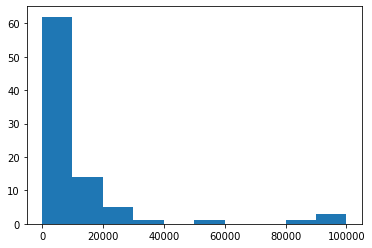

In [ ]:
plt.hist(df['standard_value'])

Distribution of `standard_value`is right skewed. So it is better to use median to impute the missing values.

In [ ]:
df['standard_value'].fillna(df['standard_value'].median(), inplace=True)

df['standard_value'].isnull().sum()

0

Check `canonical_smiles` column for duplicates.

In [ ]:
len(df.canonical_smiles.unique())

69

Drop duplicates from `canonical_smiles`.

In [ ]:
df2 = df.drop_duplicates(['canonical_smiles'])

In [ ]:
df2.shape

(69, 43)

###Data pre-processing

From `df2` keep the bioactivity data.

In [ ]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2[selection]
df3.head(10)

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL289923,NCCCC(NC(=O)c1ccc(NCC2CNc3nc(N)nc(O)c3C2)cc1)C...,4800.00000
1,CHEMBL152172,Nc1nc(N)c(CCCN(C=O)c2ccc(C(=O)NC(CCC(=O)O)C(=O...,18000.00000
3,CHEMBL153550,CN(CCCc1c(N)nc(N)nc1O)c1ccc(C(=O)NC(CCC(=O)O)C...,4300.00000
4,CHEMBL13659,Nc1nc(N)c(CCCNc2ccc(C(=O)N[C@@H](CCC(=O)O)C(=O...,630.00000
5,CHEMBL158034,Nc1nc(O)c2c(n1)NCC1CCN(c3ccc(C(=O)NC(CCC(=O)O)...,20000.00000
7,CHEMBL23699,CC(Cc1ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc1)CC1CNc2n...,0.00110
8,CHEMBL23278,CC(CC1=Nc2c(O)nc(N)nc2NC1)Cc1ccc(C(=O)NC(CCC(=...,0.00055
9,CHEMBL23388,Nc1nc(O)c2c(n1)NC[C@H](CCNc1ccc(C(=O)NC(CCC(=O...,0.00100
10,CHEMBL284013,Nc1nc(O)c2nc(CCCc3ccc(C(=O)NC(CCC(=O)O)C(=O)O)...,25000.00000
11,CHEMBL279302,Nc1nc(O)c2c(n1)NCC(CCCc1ccc(C(=O)NC(CCC(=O)O)C...,0.00005


Change dtype of column `standard_value` from object to float64.

Save `df3` to CSV file.

In [ ]:
df3.to_csv('GAR_transformylase_02_bioactivity_data_preprocessed.csv', index=False)

###Label compounds (active, inactive or intermediate)

Bioactivity data is in the IC50 unit. IC50 represents the concentration of the drug needed for the drug to have half of its curing result. The lowest the IC50 the better herapeutic capacity of the drug. 

In [ ]:
df4 = pd.read_csv('GAR_transformylase_02_bioactivity_data_preprocessed.csv')
df4.rename(columns={'standard_value': 'IC50'}, inplace = True)
print(df4.shape)
df4.head()

(69, 3)


,molecule_chembl_id,canonical_smiles,IC50
0,CHEMBL289923,NCCCC(NC(=O)c1ccc(NCC2CNc3nc(N)nc(O)c3C2)cc1)C...,4800.0
1,CHEMBL152172,Nc1nc(N)c(CCCN(C=O)c2ccc(C(=O)NC(CCC(=O)O)C(=O...,18000.0
2,CHEMBL153550,CN(CCCc1c(N)nc(N)nc1O)c1ccc(C(=O)NC(CCC(=O)O)C...,4300.0
3,CHEMBL13659,Nc1nc(N)c(CCCNc2ccc(C(=O)N[C@@H](CCC(=O)O)C(=O...,630.0
4,CHEMBL158034,Nc1nc(O)c2c(n1)NCC1CCN(c3ccc(C(=O)NC(CCC(=O)O)...,20000.0


Compounds having Ki less than **1000 nM** will be considered to be active while those having Ki greater than **10,000 nM** will be considered to be inactive. As for those with Ki values in between **1,000** and **10,000 nM** will be referred as intermediate.

In [ ]:
bioactivity_threshold = []
for i in df4.IC50:
  if i >= 10000:
    bioactivity_threshold.append("inactive")
  elif i <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")

bioactivity_class = pd.Series(bioactivity_threshold, name='class')
df5 = pd.concat([df4, bioactivity_class], axis=1)
print(df5.shape)
df5.head()

(69, 4)


,molecule_chembl_id,canonical_smiles,IC50,class
0,CHEMBL289923,NCCCC(NC(=O)c1ccc(NCC2CNc3nc(N)nc(O)c3C2)cc1)C...,4800.0,intermediate
1,CHEMBL152172,Nc1nc(N)c(CCCN(C=O)c2ccc(C(=O)NC(CCC(=O)O)C(=O...,18000.0,inactive
2,CHEMBL153550,CN(CCCc1c(N)nc(N)nc1O)c1ccc(C(=O)NC(CCC(=O)O)C...,4300.0,intermediate
3,CHEMBL13659,Nc1nc(N)c(CCCNc2ccc(C(=O)N[C@@H](CCC(=O)O)C(=O...,630.0,active
4,CHEMBL158034,Nc1nc(O)c2c(n1)NCC1CCN(c3ccc(C(=O)NC(CCC(=O)O)...,20000.0,inactive


In [ ]:
df5['class'].value_counts()

active          37
inactive        20
intermediate    12
Name: class, dtype: int64

Save `df5`, the dataframe containing the bioactivity classes, to CSV file.

In [ ]:
df5.to_csv('GAR_transformylase_03_bioactivity_data_curated.csv', index=False)